<a href="https://colab.research.google.com/github/Sunidhi-Gautam/FL_Implementation/blob/main/FL_KD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sunidhigautam26","key":"df9c2dd0e0f5995bb0a2fd692c71ec16"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

**Imports for the Dataset Download**

In [4]:
import os
import random
import shutil
import numpy as np
import torch
import timm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import json

from sklearn.metrics import classification_report
from tqdm import tqdm
from collections import Counter
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [5]:
RAW_DATASETS_DIR = "/content/raw_teacher_datasets"
os.makedirs(RAW_DATASETS_DIR, exist_ok=True)

print("Raw datasets will be stored in:", RAW_DATASETS_DIR)

Raw datasets will be stored in: /content/raw_teacher_datasets


**Dataset 1: Tomato Village**

In [6]:
print("Downloading Dataset 1: Tomato Village (GitHub)")

!git clone https://github.com/mamta-joshi-gehlot/Tomato-Village.git /content/tmp_tomato_village

shutil.move(
    "/content/tmp_tomato_village",
    os.path.join(RAW_DATASETS_DIR, "dataset_1_tomato_village")
)

print("Dataset 1 ready\n")

Cloning into '/content/tmp_tomato_village'...
remote: Enumerating objects: 45041, done.
remote: Counting objects: 100% (26934/26934), done.
remote: Compressing objects: 100% (15220/15220), done.
remote: Total 45041 (delta 11469), reused 26919 (delta 11462), pack-reused 18107 (from 1)
Receiving objects: 100% (45041/45041), 3.15 GiB | 16.14 MiB/s, done.
Resolving deltas: 100% (14334/14334), done.
Updating files: 100% (53289/53289), done.
Dataset 1 ready



**Dataset 2: Kaggle 1 (Tomato Leaf)**

In [7]:
import zipfile

print("Downloading Dataset 2: Tomato Leaf (Kaggle)")

!kaggle datasets download -d kaustubhb999/tomatoleaf -p /content

zip_path = "/content/tomatoleaf.zip"
extract_path = "/content/tmp_tomatoleaf"

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_path)

shutil.move(
    extract_path,
    os.path.join(RAW_DATASETS_DIR, "dataset_2_tomatoleaf")
)

print("Dataset 2 ready\n")

Dataset URL: https://www.kaggle.com/datasets/kaustubhb999/tomatoleaf
License(s): CC0-1.0
 82% 146M/179M [00:00<00:00, 1.50GB/s]
100% 179M/179M [00:00<00:00, 991MB/s] 
Dataset 2 ready



**Dataset 3: Kaggle 2 (Tomato – Ashish Motwani)**

In [8]:
print("Downloading Dataset 3: Tomato (Kaggle - Ashish Motwani)")

!kaggle datasets download -d ashishmotwani/tomato -p /content

zip_path = "/content/tomato.zip"
extract_path = "/content/tmp_tomato_3"

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_path)

shutil.move(
    extract_path,
    os.path.join(RAW_DATASETS_DIR, "dataset_3_tomato")
)

print("Dataset 3 ready\n")

Dataset URL: https://www.kaggle.com/datasets/ashishmotwani/tomato
License(s): copyright-authors
100% 1.37G/1.37G [00:35<00:00, 38.3MB/s]
100% 1.37G/1.37G [00:35<00:00, 41.7MB/s]
Dataset 3 ready



**Dataset 4: Kaggle 3 (Tomato Disease)**

In [9]:
print("Downloading Dataset 4: Tomato Diseases (Kaggle)")

!kaggle datasets download -d luisolazo/tomato-diseases -p /content

zip_path = "/content/tomato-diseases.zip"
extract_path = "/content/tmp_tomato_diseases"

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_path)

shutil.move(
    extract_path,
    os.path.join(RAW_DATASETS_DIR, "dataset_4_tomato_diseases")
)

print("Dataset 4 ready\n")

Dataset URL: https://www.kaggle.com/datasets/luisolazo/tomato-diseases
License(s): CC0-1.0
 78% 321M/411M [00:53<00:23, 3.96MB/s]
100% 411M/411M [00:53<00:00, 8.07MB/s]
Dataset 4 ready



**Verify Downloads**

In [10]:
print("\nFinal raw datasets available:\n")

for d in sorted(os.listdir(RAW_DATASETS_DIR)):
    print("•", d)


Final raw datasets available:

• dataset_1_tomato_village
• dataset_2_tomatoleaf
• dataset_3_tomato
• dataset_4_tomato_diseases


**Canonical Class Map**

In [11]:
CLASS_MAP = {
    # Early blight
    "early_blight": "early_blight",
    "Early_blight": "early_blight",
    "Early Blight": "early_blight",
    "tomato___early_blight": "early_blight",
    "tomato__early blight": "early_blight",
    "EARLY-BLIGHT": "early_blight",


    # Late blight
    "late_blight": "late_blight",
    "Late_blight": "late_blight",
    "Late Blight": "late_blight",
    "tomato___late_blight": "late_blight",
    "tomato__late blight": "late_blight",


    # Bacterial spot
    "bacterial_spot": "bacterial_spot",
    "Bacterial Spot": "bacterial_spot",
    "Tomato___Bacterial_spot": "bacterial_spot",
    "Tomato_bacterial_spot": "bacterial_spot",


    # Leaf mold
    "leaf_mold": "leaf_mold",
    "Leaf Mold": "leaf_mold",
    "Leaf_Mold": "leaf_mold",
    "tomato___Leaf_Mold": "leaf_mold",


    # Healthy
    "healthy": "healthy",
    "Healthy": "healthy",
    "Tomato___healthy": "healthy",


    # Target spot
    "target_spot": "target_spot",
    "Target Spot": "target_spot",
    "Target_Spot": "target_spot",
    "target_spot___": "target_spot",
    "tomato___Target_Spot": "target_spot",


    # Powdery Mildew
    "powdery_mildew": "powdery_mildew",
    "Powdery Mildew": "powdery_mildew",
    "Powdery_mildew": "powdery_mildew",
    "Powdery_Mildew": "powdery_mildew",


    # Septoria Leaf Spot
    "septoria_leaf_spot": "septoria_leaf_spot",
    "Septoria Leaf Spot": "septoria_leaf_spot",
    "Septorialeafspot": "septoria_leaf_spot",
    "tomato___Septoria_leaf_spot": "septoria_leaf_spot",


    # Mosaic virus
    "mosaic_virus": "mosaic_virus",
    "Tomato_mosaic_virus": "mosaic_virus",
    "tomato_mosaic_virus": "mosaic_virus",
    "Tomato mosaic virus": "mosaic_virus",
    "tomato___Tomato_mosaic_virus": "mosaic_virus",


    # Spider mites (Two-spotted)
    "spider_mites_two_spotted_spider_mite": "spider_mites",
    "Spider Mites Two-spotted spider_mite": "spider_mites",
    "Spider_mites": "spider_mites",
    "spider_mites": "spider_mites",
    "twospotted_spider_mite": "spider_mites",
    "Tomato___Spider_mites Two-spotted_spider_mite": "spider_mites",


    # Yellow Leaf Curl Virus
    "yellow_leaf_curl_virus": "yellow_leaf_curl_virus",
    "TomatoYellowLeafCurlVirus": "yellow_leaf_curl_virus",
    "Tomato_Yellow_Leaf_Curl_Virus": "yellow_leaf_curl_virus",
    "Yellow Leaf Curl Virus": "yellow_leaf_curl_virus",
    "tomato___Tomato_Yellow_Leaf_Curl_Virus": "yellow_leaf_curl_virus",


    # Leaf Miner
    "leaf_miner": "leaf_miner",
    "Leaf Miner": "leaf_miner",
    "leaf miner": "leaf_miner",


    # Nitrogen deficiency
    "nitrogen_deficiency": "nitrogen_deficiency",
    "Nitrogen Deficiency": "nitrogen_deficiency",


    # Potassium deficiency
    "potassium_deficiency": "potassium_deficiency",
    "Pottassium Deficiency": "potassium_deficiency",
    "Potassium Deficiency": "potassium_deficiency",


    # Magnesium deficiency
    "magnesium_deficiency": "magnesium_deficiency",
    "Magnesium Deficiency": "magnesium_deficiency",


    # Spotted Wilt Virus
    "spotted_wilt_virus": "spotted_wilt_virus",
    "Spotted Wilt Virus": "spotted_wilt_virus",
    "Spotted_Wilt_Virus": "spotted_wilt_virus",
    "Spotted wilt virus": "spotted_wilt_virus",
}

In [12]:
RAW_DATASETS_DIR = "/content/raw_teacher_datasets"
TEACHER_DATASET_DIR = "/content/teacher_dataset"

os.makedirs(TEACHER_DATASET_DIR, exist_ok=True)

In [13]:
IGNORE_FOLDERS = {
    "train", "val", "test",
    "images", "image", "imgs"
}

**Normalize Class Names**

In [14]:
def normalize_class_name(raw):
    raw = raw.strip().lower()

    # Ignore structural folders
    if raw in IGNORE_FOLDERS:
        return None

    # Remove PlantVillage prefix
    if raw.startswith("tomato___"):
        raw = raw.replace("tomato___", "")

    # Cleanup
    raw = raw.replace("-", "_")
    raw = raw.replace(" ", "_")
    raw = raw.replace("__", "_")

    # ---- Canonical merges ----

    if "spider" in raw or "mite" in raw:
        return "spider_mites"

    if "yellow" in raw and "curl" in raw:
        return "yellow_leaf_curl_virus"

    if "mosaic" in raw:
        return "mosaic_virus"

    if "septoria" in raw:
        return "septoria_leaf_spot"

    if "early" in raw and "blight" in raw:
        return "early_blight"

    if "late" in raw and "blight" in raw:
        return "late_blight"

    if "target" in raw:
        return "target_spot"

    if "leaf" in raw and "mold" in raw:
        return "leaf_mold"

    # Nutrient deficiencies
    if "nitrogen" in raw:
        return "nitrogen_deficiency"

    if "pottassium" in raw or "potassium" in raw:
        return "potassium_deficiency"

    if "magnesium" in raw:
        return "magnesium_deficiency"

    # Healthy
    if raw == "healthy":
        return "healthy"

    return raw

In [15]:
TEACHER_DATASET_DIR = "/content/teacher_dataset"

if os.path.exists(TEACHER_DATASET_DIR):
    shutil.rmtree(TEACHER_DATASET_DIR)

os.makedirs(TEACHER_DATASET_DIR)

**Merge & Normalizing All Datasets**

In [16]:
IMG_EXTS = (".jpg", ".jpeg", ".png")

class_counter = {}
total_images = 0

for dataset in sorted(os.listdir(RAW_DATASETS_DIR)):
    dataset_path = os.path.join(RAW_DATASETS_DIR, dataset)
    print(f"\nProcessing {dataset}")

    for root, _, files in os.walk(dataset_path):
        imgs = [f for f in files if f.lower().endswith(IMG_EXTS)]
        if not imgs:
            continue

        raw_class = os.path.basename(root)
        norm_class = normalize_class_name(raw_class)

        if norm_class is None:
            continue

        dest_cls_dir = os.path.join(TEACHER_DATASET_DIR, norm_class)
        os.makedirs(dest_cls_dir, exist_ok=True)

        for img in imgs:
            src = os.path.join(root, img)
            dst = os.path.join(dest_cls_dir, f"{dataset}_{img}")
            shutil.copy(src, dst)

            class_counter[norm_class] = class_counter.get(norm_class, 0) + 1
            total_images += 1


Processing dataset_1_tomato_village

Processing dataset_2_tomatoleaf

Processing dataset_3_tomato

Processing dataset_4_tomato_diseases


**Teacher Dataset Summary**

In [17]:
print("\n===== CLEAN TEACHER DATASET SUMMARY =====")
print(f"Total images: {total_images}")
print(f"Total classes: {len(class_counter)}\n")

for cls, cnt in sorted(class_counter.items()):
    print(f"{cls:<30} {cnt}")


===== CLEAN TEACHER DATASET SUMMARY =====
Total images: 70252
Total classes: 16

bacterial_spot                 6781
early_blight                   7315
healthy                        7499
late_blight                    8446
leaf_miner                     1024
leaf_mold                      6497
magnesium_deficiency           936
mosaic_virus                   5478
nitrogen_deficiency            360
potassium_deficiency           72
powdery_mildew                 1256
septoria_leaf_spot             6499
spider_mites                   4958
spotted_wilt_virus             517
target_spot                    4938
yellow_leaf_curl_virus         7676


**Teacher Dataset Splitting**

In [18]:
RAW_TEACHER = "/content/teacher_dataset"
SPLIT_DIR = "/content/teacher_dataset_split"

TRAIN_DIR = os.path.join(SPLIT_DIR, "train")
VAL_DIR = os.path.join(SPLIT_DIR, "val")
TEST_DIR = os.path.join(SPLIT_DIR, "test")

for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    if os.path.exists(d):
        shutil.rmtree(d)
    os.makedirs(d)

train_ratio = 0.7
val_ratio   = 0.15
test_ratio  = 0.15

random.seed(42)
classes = sorted(os.listdir(RAW_TEACHER))

for cls in classes:
    cls_path = os.path.join(RAW_TEACHER, cls)
    if not os.path.isdir(cls_path):
        continue
    images = os.listdir(cls_path)
    random.shuffle(images)

    n = len(images)
    n_train = int(n * train_ratio)
    n_val   = int(n * val_ratio)
    n_test  = n - n_train - n_val

    train_imgs = images[:n_train]
    val_imgs   = images[n_train:n_train+n_val]
    test_imgs  = images[n_train+n_val:]

    for folder, imgs in zip([TRAIN_DIR, VAL_DIR, TEST_DIR], [train_imgs, val_imgs, test_imgs]):
        cls_folder = os.path.join(folder, cls)
        os.makedirs(cls_folder, exist_ok=True)
        for img in imgs:
            shutil.copy(os.path.join(cls_path, img), os.path.join(cls_folder, img))

**Data Transforms & DataLoaders**

In [19]:
BATCH_SIZE = 32

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=val_transform)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=val_transform)

**Handling Class Imbalance**

**Class Frequencies**

In [20]:
# Path to train folder
train_dir = os.path.join(SPLIT_DIR, "train")

# Count samples per class in training set
class_counts = Counter()
for cls in os.listdir(train_dir):
    cls_path = os.path.join(train_dir, cls)
    if not os.path.isdir(cls_path):
        continue
    class_counts[cls] = len(os.listdir(cls_path))

print("===== CLASS FREQUENCIES (Train Set) =====")
for c, n in sorted(class_counts.items()):
    print(f"{c:<30} {n}")

===== CLASS FREQUENCIES (Train Set) =====
bacterial_spot                 4435
early_blight                   4809
healthy                        4938
late_blight                    5601
leaf_miner                     716
leaf_mold                      4237
magnesium_deficiency           655
mosaic_virus                   3523
nitrogen_deficiency            251
potassium_deficiency           50
powdery_mildew                 879
septoria_leaf_spot             4238
spider_mites                   3159
spotted_wilt_virus             361
target_spot                    3145
yellow_leaf_curl_virus         5062


**Computing Class-Balanced Weights (CB-Loss)**

$$
w_c = \frac{1 - \beta}{1 - \beta^{n_c}}
$$

n_c = no. of samples in class c

β ϵ [0.9, 0.9999]

Larger β --> stronger balancing

In [21]:
class_counts = [0]*len(train_dataset.classes)
for _, label in train_dataset.samples:
    class_counts[label] += 1

beta = 0.999
effective_num = [1 - beta**n for n in class_counts]
weights = [(1-beta)/n for n in effective_num]
weights = np.array(weights)
weights = weights / weights.sum() * len(weights)
class_weights = torch.tensor(weights, dtype=torch.float).cuda()

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

**WeightedRandomSampler***

In [22]:
MAX_CLASS_WEIGHT = 5.0
sample_weights = [min(1.0 / class_counts[label], MAX_CLASS_WEIGHT) for _, label in train_dataset.samples]

train_sampler = WeightedRandomSampler(weights=sample_weights,
                                      num_samples=len(sample_weights),
                                      replacement=True)

**DataLoaders**

In [23]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

**Loading Teacher Dataset**

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

teacher_model = timm.create_model('efficientnet_b2', pretrained=True, num_classes=len(train_dataset.classes))
teacher_model = teacher_model.to(device)

optimizer = optim.Adam(teacher_model.parameters(), lr=1e-4)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/36.8M [00:00<?, ?B/s]

**Training Loop**

In [25]:
NUM_EPOCHS = 10
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")

    # --- Training ---
    teacher_model.train()
    running_loss, correct, total = 0, 0, 0

    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)
    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = teacher_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Update live progress bar with current batch accuracy & loss
        train_loader_tqdm.set_postfix({
            "Loss": f"{running_loss/total:.4f}",
            "Acc": f"{correct/total:.4f}"
        })

    train_loss = running_loss / total
    train_acc = correct / total

    # --- Validation ---
    teacher_model.eval()
    val_running_loss, val_correct, val_total = 0, 0, 0

    val_loader_tqdm = tqdm(val_loader, desc="Validation", leave=False)
    for images, labels in val_loader_tqdm:
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            outputs = teacher_model(images)
            loss = criterion(outputs, labels)

        val_running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        val_correct += (preds == labels).sum().item()
        val_total += labels.size(0)

        val_loader_tqdm.set_postfix({
            "Loss": f"{val_running_loss/val_total:.4f}",
            "Acc": f"{val_correct/val_total:.4f}"
        })

    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total

    # --- Save history ---
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # --- Epoch summary ---
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

# Save history
torch.save(history, "teacher_history.pt")



Epoch 1/10


Train Loss: 0.2273 | Train Acc: 0.8800 | Val Loss: 0.2055 | Val Acc: 0.9392

Epoch 2/10


Train Loss: 0.0458 | Train Acc: 0.9714 | Val Loss: 0.1162 | Val Acc: 0.9653

Epoch 3/10


Train Loss: 0.0318 | Train Acc: 0.9802 | Val Loss: 0.1459 | Val Acc: 0.9680

Epoch 4/10


Train Loss: 0.0227 | Train Acc: 0.9861 | Val Loss: 0.0635 | Val Acc: 0.9827

Epoch 5/10


Train Loss: 0.0179 | Train Acc: 0.9894 | Val Loss: 0.1042 | Val Acc: 0.9747

Epoch 6/10


Train Loss: 0.0136 | Train Acc: 0.9910 | Val Loss: 0.0902 | Val Acc: 0.9780

Epoch 7/10


Train Loss: 0.0182 | Train Acc: 0.9897 | Val Loss: 0.0862 | Val Acc: 0.9778

Epoch 8/10


Train Loss: 0.0089 | Train Acc: 0.9939 | Val Loss: 0.0714 | Val Acc: 0.9821

Epoch 9/10


Train Loss: 0.0177 | Train Acc: 0.9914 | Val Loss: 0.1024 | Val Acc: 0.9786

Epoch 10/10


Train Loss: 0.0072 | Train Acc: 0.9954 | Val Loss: 0.0629 | Val Acc: 0.9835


In [26]:
torch.save(teacher_model.state_dict(), "teacher_efficientnet_b2.pth")

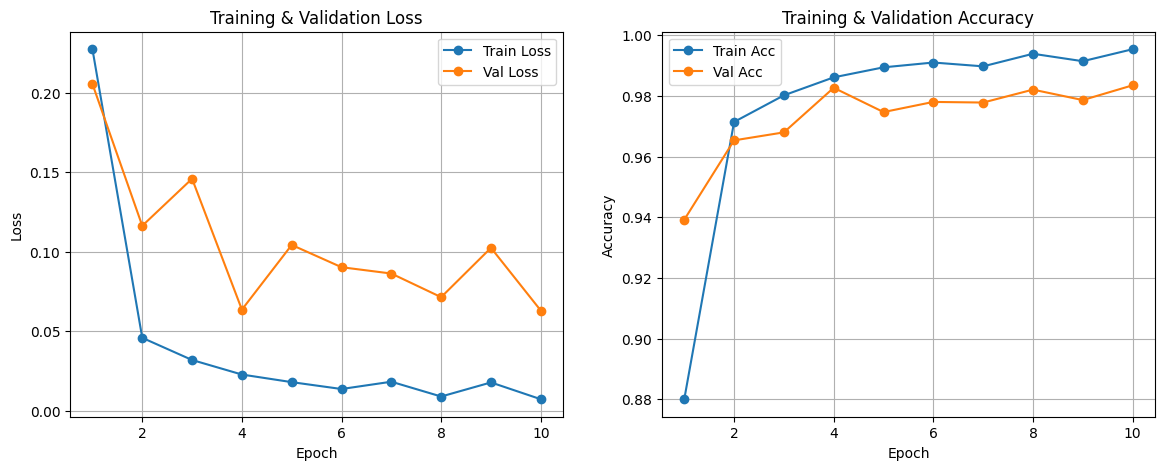

In [27]:
# --- Plot training & validation curves ---
history = torch.load("teacher_history.pt")  # Load your saved history

epochs = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(14,5))

# Loss
plt.subplot(1,2,1)
plt.plot(epochs, history['train_loss'], label='Train Loss', marker='o')
plt.plot(epochs, history['val_loss'], label='Val Loss', marker='o')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, history['train_acc'], label='Train Acc', marker='o')
plt.plot(epochs, history['val_acc'], label='Val Acc', marker='o')
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.show()

In [28]:
# --- Evaluate on test set ---
teacher_model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = teacher_model(images)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

test_acc = test_correct / test_total
print(f"Test Accuracy: {test_acc*100:.2f}%")

Test Accuracy: 98.32%


In [29]:
teacher_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = teacher_model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\n===== CLASSIFICATION REPORT (TEST SET) =====\n")
print(
    classification_report(
        all_labels,
        all_preds,
        target_names=test_dataset.classes,
        digits=4
    )
)


===== CLASSIFICATION REPORT (TEST SET) =====

                        precision    recall  f1-score   support

        bacterial_spot     0.9701    0.9874    0.9787       952
          early_blight     0.9930    0.9690    0.9809      1032
               healthy     0.9792    0.9802    0.9797      1059
           late_blight     0.9833    0.9833    0.9833      1201
            leaf_miner     0.8614    0.9226    0.8910       155
             leaf_mold     0.9956    0.9923    0.9939       909
  magnesium_deficiency     0.9324    0.9787    0.9550       141
          mosaic_virus     0.9987    0.9841    0.9913       756
   nitrogen_deficiency     0.9153    0.9818    0.9474        55
  potassium_deficiency     0.9231    1.0000    0.9600        12
        powdery_mildew     0.9947    1.0000    0.9974       189
    septoria_leaf_spot     0.9684    0.9780    0.9732       909
          spider_mites     0.9912    1.0000    0.9956       678
    spotted_wilt_virus     0.9403    0.7975    0.8630   

In [30]:
with open("teacher_classes.json", "w") as f:
    json.dump(train_dataset.classes, f)

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
import os, json, torch

SAVE_DIR = "/content/drive/MyDrive/teacher_model"
os.makedirs(SAVE_DIR, exist_ok=True)

# save model
torch.save(
    teacher_model.state_dict(),
    f"{SAVE_DIR}/teacher_efficientnet_b2.pth"
)

# save classes
with open(f"{SAVE_DIR}/teacher_classes.json", "w") as f:
    json.dump(train_dataset.classes, f)

In [34]:
experiment_info = {
    "dataset": "tomato-leaf-disease",
    "source": "Kaggle",
    "num_classes": len(train_dataset.classes),
    "classes": train_dataset.classes,
    "input_size": 260,
    "model": "efficientnet_b2",
    "epochs": 10,
    "optimizer": "AdamW",
    "best_val_acc": 0.9832
}

import json
with open("/content/drive/MyDrive/teacher_model/experiment.json", "w") as f:
    json.dump(experiment_info, f, indent=4)

In [31]:
from google.colab import files
files.upload()   # upload .pth and .json

KeyboardInterrupt: 

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open("teacher_classes.json") as f:
    classes = json.load(f)

teacher_model = timm.create_model(
    'efficientnet_b2',
    pretrained=False,        # IMPORTANT
    num_classes=len(classes)
)

teacher_model.load_state_dict(
    torch.load("teacher_efficientnet_b2.pth", map_location=device)
)

teacher_model = teacher_model.to(device)
teacher_model.eval()

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

**Saving the Datasets**

In [41]:
!rm -rf /content/drive/MyDrive/teacher_dataset

In [42]:
!mkdir -p /content/drive/MyDrive/teacher_dataset

In [43]:
!cp -r /content/teacher_dataset/* /content/drive/MyDrive/teacher_dataset/

In [44]:
SRC_SPLIT_DIR = "/content/teacher_dataset_split"
DRIVE_SPLIT_DIR = "/content/drive/MyDrive/teacher_dataset_split"

In [45]:
import shutil
import os

if os.path.exists(DRIVE_SPLIT_DIR):
    shutil.rmtree(DRIVE_SPLIT_DIR)

os.makedirs(DRIVE_SPLIT_DIR)
print("🧹 Old broken split removed")

🧹 Old broken split removed


In [46]:
shutil.copytree(SRC_SPLIT_DIR, DRIVE_SPLIT_DIR, dirs_exist_ok=True)
print("✅ Teacher split dataset saved to Drive correctly")

✅ Teacher split dataset saved to Drive correctly


In [48]:
!cp teacher_history.pt /content/drive/MyDrive/

In [49]:
!ls /content/drive/MyDrive/teacher_dataset

bacterial_spot	magnesium_deficiency  spider_mites
early_blight	mosaic_virus	      spotted_wilt_virus
healthy		nitrogen_deficiency   target_spot
late_blight	potassium_deficiency  yellow_leaf_curl_virus
leaf_miner	powdery_mildew
leaf_mold	septoria_leaf_spot


In [50]:
!find /content/drive/MyDrive/teacher_dataset -maxdepth 1 -type d

/content/drive/MyDrive/teacher_dataset
/content/drive/MyDrive/teacher_dataset/bacterial_spot
/content/drive/MyDrive/teacher_dataset/early_blight
/content/drive/MyDrive/teacher_dataset/healthy
/content/drive/MyDrive/teacher_dataset/late_blight
/content/drive/MyDrive/teacher_dataset/leaf_miner
/content/drive/MyDrive/teacher_dataset/leaf_mold
/content/drive/MyDrive/teacher_dataset/magnesium_deficiency
/content/drive/MyDrive/teacher_dataset/mosaic_virus
/content/drive/MyDrive/teacher_dataset/nitrogen_deficiency
/content/drive/MyDrive/teacher_dataset/potassium_deficiency
/content/drive/MyDrive/teacher_dataset/powdery_mildew
/content/drive/MyDrive/teacher_dataset/septoria_leaf_spot
/content/drive/MyDrive/teacher_dataset/spider_mites
/content/drive/MyDrive/teacher_dataset/spotted_wilt_virus
/content/drive/MyDrive/teacher_dataset/target_spot
/content/drive/MyDrive/teacher_dataset/yellow_leaf_curl_virus


In [51]:
!ls /content/drive/MyDrive/teacher_dataset_split

test  train  val


In [53]:
!find /content/drive/MyDrive/teacher_dataset_split/ -maxdepth 2 -type d

/content/drive/MyDrive/teacher_dataset_split/
/content/drive/MyDrive/teacher_dataset_split/test
/content/drive/MyDrive/teacher_dataset_split/test/leaf_miner
/content/drive/MyDrive/teacher_dataset_split/test/leaf_mold
/content/drive/MyDrive/teacher_dataset_split/test/powdery_mildew
/content/drive/MyDrive/teacher_dataset_split/test/late_blight
/content/drive/MyDrive/teacher_dataset_split/test/yellow_leaf_curl_virus
/content/drive/MyDrive/teacher_dataset_split/test/spotted_wilt_virus
/content/drive/MyDrive/teacher_dataset_split/test/septoria_leaf_spot
/content/drive/MyDrive/teacher_dataset_split/test/bacterial_spot
/content/drive/MyDrive/teacher_dataset_split/test/potassium_deficiency
/content/drive/MyDrive/teacher_dataset_split/test/healthy
/content/drive/MyDrive/teacher_dataset_split/test/spider_mites
/content/drive/MyDrive/teacher_dataset_split/test/target_spot
/content/drive/MyDrive/teacher_dataset_split/test/nitrogen_deficiency
/content/drive/MyDrive/teacher_dataset_split/test/early_

**Reloading From Drive**

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
TEACHER_DATASET_DIR = "/content/drive/MyDrive/teacher_dataset"
SPLIT_DIR = "/content/drive/MyDrive/teacher_dataset_split"

In [58]:
teacher_model.load_state_dict(
    torch.load("/content/drive/MyDrive/teacher_efficientnet_b2.pth")
)

<All keys matched successfully>

In [59]:
teacher_model = teacher_model.to(device)
teacher_model.eval()

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

In [60]:
from sklearn.metrics import confusion_matrix
teacher_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = teacher_model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [61]:
class_names = test_dataset.classes   # safest
print(class_names)

['bacterial_spot', 'early_blight', 'healthy', 'late_blight', 'leaf_miner', 'leaf_mold', 'magnesium_deficiency', 'mosaic_virus', 'nitrogen_deficiency', 'potassium_deficiency', 'powdery_mildew', 'septoria_leaf_spot', 'spider_mites', 'spotted_wilt_virus', 'target_spot', 'yellow_leaf_curl_virus']


In [62]:
cm = confusion_matrix(all_labels, all_preds)

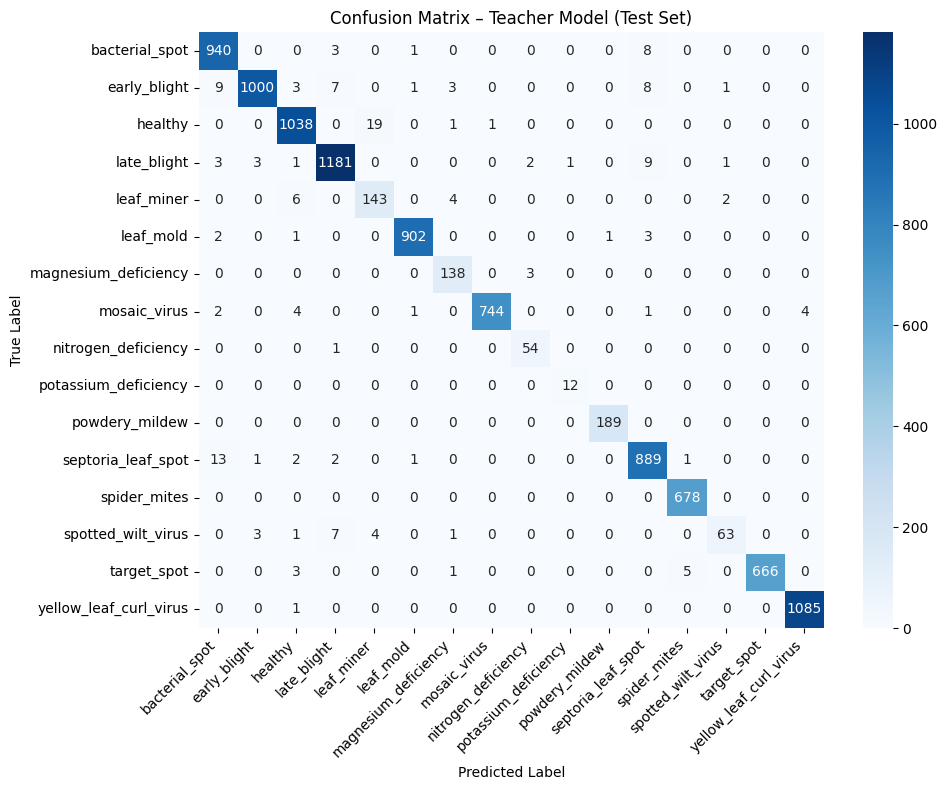

In [67]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Teacher Model (Test Set)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

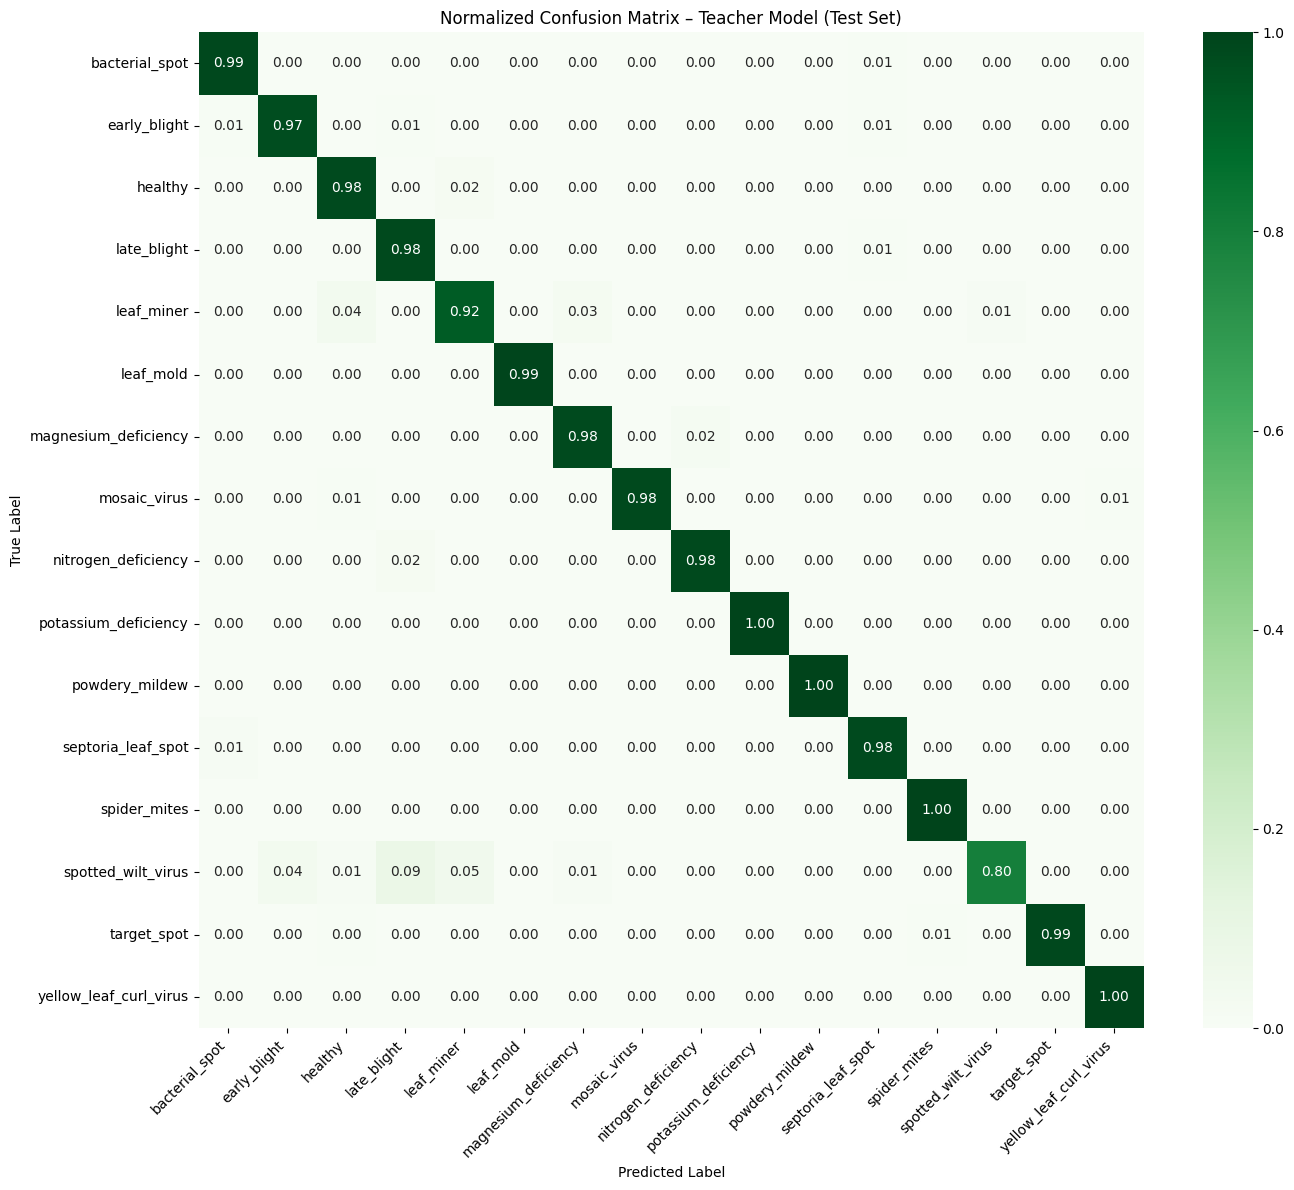

In [66]:
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Greens",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix – Teacher Model (Test Set)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()